In [ ]:
!pip install --upgrade git+https://github.com/matthias-wright/flaxmodels.git
!pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/matthias-wright/flaxmodels.git to /tmp/pip-req-build-rjd29ar9
  Running command git clone -q https://github.com/matthias-wright/flaxmodels.git /tmp/pip-req-build-rjd29ar9
     |████████████████████████████████| 197 kB 7.8 MB/s 
     |████████████████████████████████| 8.3 MB 48.7 MB/s 
     |████████████████████████████████| 154 kB 58.6 MB/s 
     |████████████████████████████████| 66 kB 1.7 MB/s 
     |████████████████████████████████| 237 kB 77.0 MB/s 
     |████████████████████████████████| 51 kB 7.9 MB/s 
     |████████████████████████████████| 85 kB 5.4 MB/s 
  Created wheel for flaxmodels: filename=flaxmodels-0.1.2-py3-none-any.whl size=115737 sha256=4cf83a6139c72a50dd624ef2a1bc78ae316fb6e11b4b2f79e983b6cffc9f0ba4
  Stored in directory: /tmp/pip-ephem-wheel-cache-40xyg7uo/wheels/b1/16/4e/6e7f5aa6a1c912db017f34a3bdf96761478b3cfdb907009951
Successfully buil

In [ ]:
from PIL import Image
import jax
import jax.numpy as jnp
import flaxmodels as fm
import matplotlib.pyplot as plt
from jax import jit, random, grad
import numpy as np

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec 18 23:05:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    27W /  70W |  13610MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
!wget https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg

--2022-12-18 23:05:15--  https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
Resolving pytorch.org (pytorch.org)... 185.199.109.153, 185.199.111.153, 185.199.108.153, ...
Connecting to pytorch.org (pytorch.org)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114573 (112K) [image/jpeg]
Saving to: ‘picasso.jpg’

picasso.jpg         100%[===================>] 111.89K  --.-KB/s    in 0.002s  

2022-12-18 23:05:16 (54.3 MB/s) - ‘picasso.jpg’ saved [114573/114573]

--2022-12-18 23:05:16--  https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg
Resolving pytorch.org (pytorch.org)... 185.199.109.153, 185.199.111.153, 185.199.108.153, ...
Connecting to pytorch.org (pytorch.org)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40484 (40K) [image/jpeg]
Saving to: ‘dancing.jpg’

dancing.jpg         100%[===================>]  39.54K  --.-KB/s    in 0s      

2022-12-18 23:05:16 (106 MB/s) 

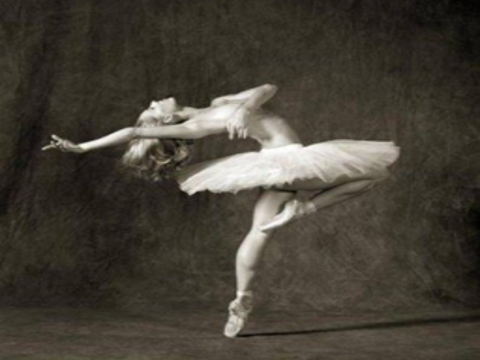

In [ ]:
# Load image
img_con = Image.open('dancing.jpg').resize((256,256))
display(img_con.resize((480, 360)))

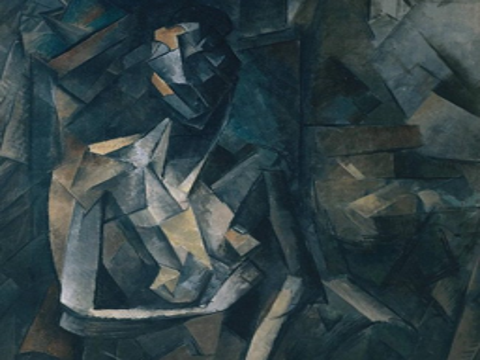

In [ ]:
img_sty = Image.open('picasso.jpg').resize((256,256))
display(img_sty.resize((480, 360)))

In [ ]:
cnn_normalization_mean = jnp.array([0.485, 0.456, 0.406])
cnn_normalization_std = jnp.array([0.229, 0.224, 0.225])

In [ ]:
# Image should be in range [0, 1]
image_content = jnp.array(img_con, dtype=jnp.float32) / 255.0

# Add batch dimension
img_content = jnp.expand_dims(image_content, axis=0)

In [ ]:
image_style = jnp.array(img_sty, dtype=jnp.float32) / 255

img_style = jnp.expand_dims(image_style, axis=0)

In [ ]:
vgg19 = fm.VGG19(output='activations', pretrained='imagenet', include_head=False)
init_rngs = {'params': jax.random.PRNGKey(0)}#, 'dropout': jax.random.PRNGKey(1)}
params = vgg19.init(init_rngs, img_content)
# Apply function: Get a output of each layer activation.
fn_out = jit(vgg19.apply)

Downloading: "https://www.dropbox.com/s/1sn02fnkj579u1w/vgg19_weights.h5" to /tmp/flaxmodels/vgg19_weights.h5


100%|██████████| 575M/575M [00:35<00:00, 16.2MiB/s]


In [ ]:
@jit
def content_loss(input_content, img_generated):
  return jnp.mean((input_content.flatten()-img_generated.flatten()) ** 2)

In [ ]:
@jit
def gram_matrix(input):
  input = jnp.transpose(input, axes=(0, 3, 1, 2))
  a, b, c, d = input.shape #a=1, batchsize, b=3 number of feature maps, (c,d) size of feature map
  features = input.reshape(a * b, c * d)
  G = features @ features.T
  return G / (a * b * c * d)

In [ ]:
@jit
def style_loss(input_style, img_generated):
  return jnp.mean((input_style - img_generated) ** 2)

In [ ]:
content_layers_default = ['conv2_2']
style_layers_default = ['conv1_1', 'conv1_2', 'conv2_1', 'conv2_2', 'conv3_1']

out_content = fn_out(params, img_content, train=False)
out_style = fn_out(params, img_style, train=False)


In [ ]:
@jit
def Loss(img_generated, style_weight = 1000000, content_weight=1):

  pre_model =fn_out

  
  out_generated = pre_model(params, img_generated, train=False)

  style_score = 0
  content_score = 0

  for cont_layer in content_layers_default:
    content_score += content_loss(out_content[cont_layer], out_generated[cont_layer])

  for sty_layer in style_layers_default:
    gram_sty = gram_matrix(out_style[sty_layer])
    gram_gen = gram_matrix(out_generated[sty_layer])
    style_score += style_loss(gram_sty, gram_gen)


  loss = style_weight * style_score + content_weight * content_score
  #print('Style Loss:', style_score * style_weight, 'Content Loss:', content_score * content_weight,'Total Loss:', loss)

  return loss



In [ ]:
grad_loss = jit(grad(Loss, 0))

In [ ]:
import optax
lr = 1e-3
optimizer = optax.adam(
            learning_rate=lr,
)

In [ ]:
init_params = img_content.copy()

In [ ]:
opt_state = optimizer.init(init_params)
generate_params=init_params

In [ ]:
@jit
def train_step(optimizer_state, img_generated):
  grads = grad_loss(img_generated)
  updates, opt_state = optimizer.update(grads, optimizer_state, img_generated)
  return optax.apply_updates(img_generated, updates), opt_state

In [ ]:
from tqdm import trange

In [ ]:
for iter in trange(500):
  generate_params = jnp.clip(generate_params, 0,1)
  generate_params, opt_state = train_step(opt_state, generate_params)



In [ ]:
generate_params = jnp.clip(generate_params, 0,1)

In [ ]:
plt.imshow(generate_params[0])